In [1]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
FOLDER_PATH = '/content/drive/MyDrive/music-retrival'

FRAME_SIZE = 2048
HOP_LENGTH = int(22050 // 31.25)
DURATION = 15 # In seconds
SAMPLE_RATE = 22050
N_FFT = 2048
N_MELS = 128
MONO = True

SPECTROGRAM_313x149_SAVE_DIR = FOLDER_PATH+ "/spectograms_313x149_Mel_func"
FILES_DIR = FOLDER_PATH+"/data-emotion/set2/Soundtrack360_mp3"

In [ ]:
class Loader:
    # loader is responsible for loading the audio file

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        #y: Vector 1D amptiplude across time
        #sr: sampling frequency (HZ), the number of samples of audio data captured per second
        y, sr = librosa.load(file_path)
        if sr !=  self.sample_rate:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.sample_rate)
        return y


class Padder:
    # Padder is responsible to apply padding to an array

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    # LogSpectrogramExtractor extracts log spectrogram (in dB) from a time series signal
    # Fourier Transform

    def __init__(self, frame_size, hop_length):
        self.frame_rate = frame_size
        self.hop_length = hop_length

    def _random_10s(self, signal):
        section_start = np.random.randint(0, signal.shape[0] - 10 * 22050)
        section_end = section_start + 10 * 22050
        section = signal[section_start:section_end]
        return section

    def extract(self, spec_type, signal):
        try:
            if spec_type == "MEL":
                return self._extract_mel(signal)
            elif spec_type == "STFT":
                return self._extract_stft(signal)
            raise Exception('MEL', 'STFT')
        except Exception as inst:
            print("Only Mel-Spec and STFT-Spec is handled: ", inst.args)

    def _extract_stft(self, signal):
    
        
        # Select a random 10-second section
        signal = self._random_10s(signal)
        
        frames = librosa.util.frame(signal, frame_length=self.frame_rate, hop_length=self.hop_length)
        

        frames_normalized = librosa.util.normalize(frames)

        spec = np.abs(librosa.stft(frames_normalized)) ** 2
        log_spec = librosa.amplitude_to_db(spec, ref=np.max)

        # Resize the spectrogram to 313x149 
        spectrogram = librosa.util.fix_length(log_spec[:,:,0], size=149, axis=1)
        spectrogram = librosa.util.fix_length(spectrogram, size=313, axis=0)
        return spectrogram

    def _extract_mel(self, signal):
        signal = self._random_10s(signal)

        spectrogram = librosa.feature.melspectrogram(y=signal, sr=22050, n_fft=2048, hop_length=self.hop_length, n_mels=149)

        # convert to decibel scale
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

        # transpose to have time as the first dimension and frequency as the second dimension
        spectrogram_db = np.transpose(spectrogram_db)

        return spectrogram_db

class Saver:
    # Saver is responsible to save features, and the min max values

    def __init__(self, feature_save_dir):
        self.feature_save_dir = feature_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        with open(save_path, 'wb') as f:
            np.save(f, feature, allow_pickle=True)
        return save_path

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path


class PreprocessingPipeline:
    """
    PreprocessingPipeline processes audio files in a directory,
    applying the following to each file
        1 - load a file
        2 - pad the signal (if necessary)
        3 - extracting log spectrogram from signal
        4 - normalise spectrogram
        5 - save the normalised signal
    storing all the min max values for all the log spectrogram
    """

    def __init__(self, spec_type = "MEL"):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None
        self.spectrogram_type = spec_type

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(self.loader.sample_rate * self.loader.duration)

    def process(self, audio_files_directory):
        # print(os.walk(audio_files_directory))
        for root, _, files in os.walk(audio_files_directory):
            for file in files:
                file_path = os.path.join(root, file)
                self._process_file(file_path)
                print(f"Processed file {file_path}")

    def _process_file(self, file_path):
        signal = self.loader.load(file_path)
        feature = self.extractor.extract(self.spectrogram_type, signal)
        save_path = self.saver.save_feature(feature, file_path)

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

In [ ]:
if __name__ == "__main__":

    loader = Loader(SAMPLE_RATE, DURATION, MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
    saver = Saver(SPECTROGRAM_313x149_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.saver = saver
    

    preprocessing_pipeline.process(FILES_DIR)

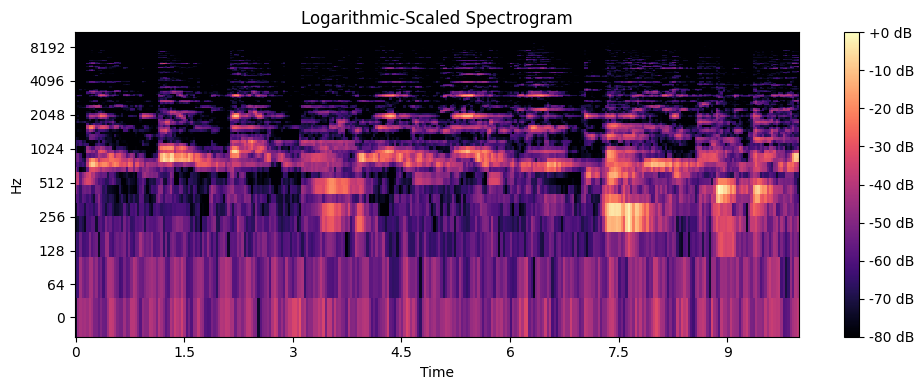

In [15]:
spec_npy = np.load(SPECTROGRAM_313x149_SAVE_DIR+'/3.mp3.npy')
#Load Logarithmic-Scaled Spectrogram'
plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_npy.T, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Logarithmic-Scaled Spectrogram')
plt.tight_layout()
plt.show()